In [10]:
import numpy as np
from numpy.linalg import norm

import requests
import mwclient
from mwclient import Site
from mwclient.page import Page

import string
import re

import nltk
import nltk.corpus

from queue import PriorityQueue

import warnings
warnings.filterwarnings('ignore')

In [11]:
class TreeNode(object):
    def __init__(self, value, parent=None):
        self.value = value
        self.parent = parent
        self.children= []
    
    def add_child(self, obj):
        self.children.append(obj)

In [3]:
import io

def load_vectors(fname, skip_first_line=True):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    
    if skip_first_line:
        fin.readline()

    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.asarray([float(token) for token in tokens[1:]])
    return data

def normalize_vectors(vectors):
    return {word: vector / np.linalg.norm(vector) for word, vector in vectors.items()}
        

vectors = load_vectors("embeddings/wiki-news-300d-1M.vec")
vectors = normalize_vectors(vectors)

/home/tadija/miniconda3/envs/wikiracer/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
stopwords = set(nltk.corpus.stopwords.words('english'))

ua = 'WikiRacer/0.1 (radusinovictadija@gmail.com)'

wiki = Site('en.wikipedia.org', clients_useragent=ua)
wiki_api = 'http://en.wikipedia.org/w/api.php'

generator = wiki.random(0, 1)

meaningless_tokens = [',', '.', '\'' , '', '"', '-', '_', '–', '&', '\'\'', '""']

In [13]:
def get_random_page(gen):
    for rand in gen:
        return Page(wiki, rand['title'])
    
def parse_summary(summary): 
    tokens = [word for word in nltk.word_tokenize(summary) if word.lower() not in stopwords and word not in meaningless_tokens]
    
    trans = str.maketrans('', '', '[]().,;:|`')
    
    tokens = [token.translate(trans) for token in tokens]
    tokens = [token for token in tokens if token != '']
    
    return tokens

def get_page_summary(page):
    query_params = {
                    'action': 'query',
                    'prop': 'extracts',
                    'exintro': '',
                    'explaintext': '',
                    'pageids': page.pageid,
                    'format': 'json'
                   }
    
    headers = {
        'User-Agent': ua
    }
    
    r = requests.get(wiki_api, params=query_params, headers=headers).json()
    return parse_summary(r['query']['pages'][str(page.pageid)]['extract'])

In [14]:
def race(start, goal):
    goal_tokens = get_page_summary(goal)[:20]    
    print(goal_tokens)
    
    pq = PriorityQueue(50000)
    visited = set()
    visited_sim = set()
    
    root = TreeNode(start)
    
    curr = start
    curr_node = root
    
    while curr.pageid != goal.pageid:
        print(curr.name)
        for link in curr.links(0):
            if link.pageid not in visited:
                curr_node.add_child(TreeNode(link, parent=curr_node))
                visited.add(link.pageid)
            else:
                continue
                

            link_tokens = link.name.translate(str.maketrans('', '', '()')).split(' ')
            
            
            cnt = 0
            sim = 0
            
            for link_token in link_tokens:
                if link_token in vectors and link_token not in stopwords:
                    cnt += 1
                    
                    for ind, goal_token in enumerate(goal_tokens):
                        if goal_token in vectors:                            
                            sim += np.dot(vectors[link_token], vectors[goal_token]) * 0.75**ind                    
            
            if cnt:
                sim /= cnt
                
                if sim not in visited_sim:
                    visited_sim.add(sim)
                    pq.put([-sim, curr_node.children[-1]])
            
        if not pq.empty():
            curr_node = pq.get()[1]
            curr = curr_node.value
        else:
            print('Search failed')
            return
        
    print(curr.name)
    
    print("--------------------------")
    print("Path found:")
    while(curr_node is not None):
        print(curr_node.value.name)
        curr_node = curr_node.parent
    
    return

In [15]:
start_page = get_random_page(generator)
end_page = get_random_page(generator)

In [8]:
race(start_page, end_page)

/home/tadija/miniconda3/envs/wikiracer/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['arc-eye', 'hawkfish', 'Paracirrhites', 'arcatus', 'species', 'hawkfish', 'belonging', 'genus', 'Paracirrhites', 'found', 'shallow', 'waters', 'tropical', 'IndoPacific', 'reefs', 'resting', 'coral', 'heads', 'much', 'time']
Administration Building (Lake Erie College)
Lake County, Ohio
Great Black Swamp
Platanus occidentalis
Platanaceae
Willd.
Relict
Catocala relicta
Catocala
Minucia lunaris
Amphipyra berbera
Catocala davidi
Catocala californiensis
Catocala naumanni
Catocala thomsoni
Catocala robinsoni
Catocala dissimilis
Catocala caesia
Catocala umbrosa
Catocala benjamini
Catocala robinsonii
Catocala butleri
Catocala nubila
Catocala vidua
Catocala maculata
Catocala disjuncta
Catocala mesopotamica
Catocala brandti
Catocala praeclara
Photinia melanocarpa
Catocala neglecta
Catocala nebulosa
Catocala flavescens
Crypsis
Uroplatus sikorae
Uroplatus fimbriatus
Uroplatus giganteus
Crypsis (genus)
Munroa squarrosa
Sporobolus virginicus
Sporobolus
Sporobolus texanus
Aimophila
Sporobolus caroli


Hemidactylus pumilio
Cyrtodactylus septentrionalis
Cyrtodactylus serratus
Ceratium furca
Arfak astrapia
Red-eared firetail
Malurus splendens
Platycercus icterotis
Neophema petrophila
Bossiaea
Bossiaea tasmanica
Bossiaea rupicola
Bossiaea rhombifolia
Bossiaea arenicola
Astartea fascicularis
Taeniopygia guttata castanotis
Bossiaea buxifolia
Bossiaea bracteosa
Bossiaea foliosa
Jacksonia horrida
Bossiaea halophila
Bossiaea prostrata
Bossiaea stenophylla
Bossiaea brownii
Olearia axillaris
Hemidactylus giganteus
Euodice malabarica
Cacatuidae
Gehyra variegata
Hemidactylus minutus
Prorocentrum
Cyrtodactylus montanus
Scolopendra gigantea
Oriolus oriolus
Red-throated bee-eater
Cyrtodactylus aequalis
Hemidactylus vietnamensis
Olearia
Olearia solandri
Olearia bullata
Olearia lyallii
Olearia decurrens
Olearia oppositifolia
Olearia gardneri
Olearia colensoi
Olearia alpicola
Olearia teretifolia
Olearia lacunosa
Olearia erubescens
Olearia polita
Gehyra punctata
Cyrtodactylus nepalensis
Olearia suffrut

Hemiscyllium michaeli
Lutjanus analis
Pristiophorus japonicus
Carcharodon
Porbeagle
Ogcocephalus porrectus
Blue-spotted grouper
Carcharhinidae
Amphiprion pacificus
Alphestes immaculatus
Takifugu rubripes
Chromis analis
Cryptotomus roseus
Negaprion brevirostris
Striated surgeonfish
Chaetodon auriga
Pristiophorus delicatus
Holocephali
Hydrolagus colliei
Acanthopagrus latus
Gobiodon histrio
Acanthurus japonicus
Thalassoma pavo
Tunicate
Botrylloides violaceus
Megalodicopia hians
Clavelina moluccensis
Oikopleura cophocerca
Pyura pachydermatina
Clathrina
Clathrina macleayi
Clathrina ceylonensis
Clathrina coriacea
Clathrina hondurensis
Clathrina lacunosa
Ascidiacea
Nembrotha lineolata
Nembrotha
Nembrotha cristata
Nembrotha milleri
Oikopleura dioica
Polycarpa aurata
Clathrina pedunculata
Tambja sagamiana
Ascidians
Clathrina ramosa
Polycarpa
Cnemidocarpa finmarkiensis
Kinorhyncha
Clathrina pulcherrima
Pomacentrus caeruleus
Etmopterus polli
Chromis scotti
Etmopterus granulosus
Pliotrema warreni


Slender sawtail catshark
Dwarf sawshark
Lepomis
Lepomis auritus
Lepomis miniatus
Lepomis megalotis
Lepomis marginatus
Micropterus
Lepomis punctatus
Cyprinodontiformes
Cyprinodontidae
Poeciliidae
Cyprinodon variegatus
Poecilia
Endler's livebearer
Poeciliopsis monacha
Ostariophysi
Danionella translucida
Oryzias
Oryzias sarasinorum
Oryzias marmoratus
Oryzias javanicus
Oryzias latipes
Oryzias luzonensis
Oryzias celebensis
Characidae
Hyphessobrycon
Hyphessobrycon bifasciatus
Hyphessobrycon columbianus
Hyphessobrycon flammeus
Hyphessobrycon boulengeri
Pygopristis denticulata
Hyphessobrycon eques
Pomacentrus pavo
Echinostoma
Blackspotted puffer
Polychaete
Alitta virens
Alitta
Alitta succinea
Carcinus maenas
Sacculina
Liocarcinus holsatus
Argopecten irradians
Callistoctopus macropus
Placopecten magellanicus
Laevistrombus canarium
Coenobita violascens
Mytilidae
Bathymodiolus
Halophila
Paphies ventricosa
Hydrocharitaceae
Cepaea nemoralis
Argopecten purpuratus
Lobatus costatus
Lobatus
Halophila j

Enneapterygius atriceps
Enneapterygius kermadecensis
Helcogramma obtusirostris
Helcogramma springeri
Black-throated triplefin
Enneapterygius obscurus
Enneapterygius fasciatus
Enneapterygius minutus
Syngnathus acus
Syngnathidae
Helcogramma striata
Rough-head whiptail
Syngnathus exilis
Girdled wrasse
Flagtail pipefish
Enneapterygius similis
Blue-eyed triplefin
Helcogramma rosea
Dunckerocampus chapmani
Clark's anemonefish
Yellowfin goatfish
Najas madagascariensis
Mergus merganser
Farlowella rugosa
Chaetodon larvatus
Lepidosperma filiforme
Mesocyclops
Platanthera micrantha
Ruppia tuberosa
Euthyneura
Berthella martensi
Fringilla
Xanthorrhoea
Xanthorrhoea preissii
Xanthorrhoea platyphylla
Xanthorrhoea caespitosa
Xanthorrhoea johnsonii
Allocasuarina globosa
Fimbriated moray
Strombus peruvianus
Nerita signata
Fundulus
Blackstripe topminnow
Fundulus diaphanus diaphanus
Fundulus diaphanus
Fundulus notatus
Fundulus luciae
Fundulus lineolatus
Fundulus olivaceus
Fundulus relictus
Fundulus albolinea

Calliphora livida
Cochliomyia macellaria
Chrysomya albiceps
Dittrichia viscosa
Utetheisa pulchella
Heliotropium
Utetheisa
Utetheisa galapagensis
Utetheisa pectinata
Utetheisa specularis
Heliotropium argenteum
Heliotropium dentatum
Utetheisa timorensis
Utetheisa cruentata
Heliotropium tenellum
Tournefortia
Heliotropium wagneri
Utetheisa varians
Utetheisa limbata
Anchusa
Anchusa azurea
Utetheisa lactea
Heliotropium aff. wagneri
Utetheisa sumatrana
Utetheisa antennata
Lithospermum
Lithospermum parviflorum
Tournefortia ramosissima
Lithospermum latifolium
Utetheisa albipuncta
Tournefortia argentea
Utetheisa inconstans
Heliotropium nigricans
Nyctemera
Nyctemera chromis
Nyctemera lunulata
Nyctemera seychellensis
Chiromachla seychellensis
Nyctemera undulata
Nyctemera lugens
Nyctemera calcicola
Nyctemera uniformis
Xylecata uniformis
Nyctemera kinabaluensis
Nyctemera muelleri
Nyctemera pallescens
Chiromachla pallescens
Nyctemera luzonica
Nyctemera luzonensis
Nyctemera swinhoei
Nyctemera sumatren

Tragocephala pulchra
Euxesta freyi
Leucauge mariana
Leucauge decorata
Trox
Trox sordidus
Trox spinulosus
Trox hamatus
Trox hispidus
Trox tuberculatus
Trox robinsoni
Trox scaber
Trox sulcatus
Trox striatus
Trox plicatus
Argiope pulchella
Agrilus floridanus
Anolis carolinensis
Anolis
Chamaeleonidae
Anolis ecomorph
Snail-case caddisfly
Parcoblatta virginica
Botanophila lobata
Cleridae
Necrobia ruficollis
Trichodes ornatus
Trichodes
Trichodes bicinctus
Trichodes olivieri
Trichodes peninsularis
Necrobia rufipes
Trichodes creticus
Necrobia violacea
Sarcophaga
Sarcophaga haemorrhoidalis
Sarcophaga bullata
Catopsis berteroniana
Lathraea
Aldrovanda
Genlisea
Genlisea pulchella
Genlisea pygmaea
Heliamphora
Heliamphora tatei
Heliamphora arenicola
Heliamphora pulchella
Heliamphora purpurascens
Genlisea hispidula
Genlisea violacea
Genlisea filiformis
Heliamphora nutans
Genlisea margaretae
Heliamphora uncinata
Heliamphora ciliata
Hedbergia longiflora
Droseraceae
Triphyophyllum peltatum
Genlisea tuber

Gnetum latifolium
Acianthera micrantha
Aeshna juncea
Boloria alaskensis
Phlebotomus
Euxesta nigricans
Lophorina superba
Laridae
Thalasseus
Chlidonias
Chroicocephalus
Black-legged kittiwake
Auks
Red-legged kittiwake
Spondias pinnata
Trachidermus fasciatus
Euxesta pacifica
Euxesta sanguinea
Metzneria
Black-capped tinamou
Corydoras fowleri
Agrilus parvus
White-throated tinamou
Sepiola aurantiaca
Reclinervellus nielseni
Nyctemera obtusa
Bathymodiolus thermophilus
Grey-headed chachalaca
Asphodelus albus
Gastrotricha
Lined topminnow
Littoraria bengalensis
Adenia fruticosa
Tenthredo
Tenthredo livida
Pteridium
Tenthredo olivacea
Tenthredo obsoleta
Tenthredo amoena
Tenthredo balteata
Tenthredo brevicornis
Trox capillaris
Chthamalus fragilis
Black-necked aracari
Characiformes
Rasbora reticulata
Trigona spinipes
Walckenaeria
Walckenaeria crocea
Walckenaeria digitata
Walckenaeria spiralis
Walckenaeria castanea
Adenia glauca
Egregia menziesii
Clownfish
Tournefortia pubescens
Nyctemera browni
Cinera

Pseuderanthemum tuberculatum
Strobilanthes sinuata
Endoclita
Endoclita chrysoptera
Endoclita williamsi
Endoclita sericeus
Endoclita malabaricus
Endoclita davidi
Endoclita hosei
Macaranga
Macaranga taitensis
Macaranga mauritiana
Macaranga denticulata
Macaranga venosa
Clerodendrum
Pachliopta aristolochiae
Atrophaneura aidoneus
Pachliopta atropos
Atrophaneura semperi
Pachliopta mariae
Clerodendrum floribundum
Clerodendrum splendens
Endoclita annae
Clerodendrum viscosum
Atrophaneura varuna
Clerodendrum umbellatum
Endoclita auratus
Aegiphila
Aegiphila sellowiana
Aegiphila purpurascens
Aegiphila glomerata
Aegiphila caymanensis
Alternanthera philoxeroides
Barleria obtusa
Aegiphila panamensis
Clerodendrum paniculatum
Strobilanthes crispa
Macaranga triloba
Strobilanthes capitata
Macaranga peltata
Mallotus tetracoccus
Strobilanthes involucrata
Macaranga grandifolia
Bridelia
Cleistanthus collinus
Cleistanthus
Cleistanthus sumatranus
Bridelia tenuifolia
Aegiphila sordida
Macaranga carolinensis
Glo

Merops albicollis
Merops breweri
Black-throated shrikebill
Hibbertia longifolia
Hyraxes
Flatfish
Longfin sanddab
Five-rayed sanddab
Paralichthys lethostigma
Hypsopsetta macrocephala
Cynoglossus acutirostris
Pleuronectidae
Cynoglossus acaudatus
Rhombosolea plebeia
Cynoglossus bilineatus
Cynoglossus carpenteri
Cynoglossus attenuatus
Speckled sanddab
Cynoglossus abbreviatus
Cynoglossus browni
Cynoglossus dispar
Cynoglossus dubius
Cynoglossus canariensis
Ocellated turbot
Trox laticollis
Dusky indigobird
Vidua purpurascens
Prionailurus
Littorina obtusata
Synodontis multipunctatus
Dioecious
Xysticus ulmi
Gymnothorax hansi
Mutillidae
Paraponera clavata
Paraponera
Guarea
Guarea corrugata
Guarea guentheri
Teiidae
Aspidoscelis
Aspidoscelis guttatus
Aspidoscelis gularis
Aspidoscelis inornatus
Cnemidophorus
Aspidoscelis marmoratus
Aspidoscelis scalaris
Aspidoscelis costatus
Aspidoscelis angusticeps
Tupinambis
Cnemidophorus splendidus
Ameiva
Ameiva ameiva
Ameiva fuliginosa
Aspidoscelis mexicanus
As

Alepidea peduncularis
Chaerophyllum bulbosum
Peucedanum ostruthium
Ligusticum scoticum
Litsea cubeba
Aframomum corrorima
Zanthoxylum piperitum
Engraulis japonicus
Tasmannia lanceolata
Drimys
Tasmannia
Tasmannia purpurascens
Lophozonia moorei
Tasmannia monticola
Psittacus erithacus
Agrilus parkeri
Bowerbird
Streaked bowerbird
White-eared catbird
Black-eared catbird
Chaetodon lunula
Arctophila fulva
Lindl.
Saddled seabream
Trithemis dorsalis
Utetheisa distincta
Corydoras kanei
Alcidae
Sonchus palustris
Sonneratia ovata
Agyneta dentifera
Aphanius dispar dispar
Polycarpa fibrosa
Molgula oculata
Polyphaenis sericata
Tragocephala alluaudi
Olive-backed pipit
Halictidae
Halictus rubicundus
Halictus
Halictus parallelus
Halictus confusus
Augochlora
Alcithoe hedleyi
Brocchinia serrata
Euxesta bifasciata
Blacktip grouper
Philometra fasciati
Agamidae
Uromastyx
Uromastyx ocellata
Uromastyx thomasi
Iguanidae
Ctenosaura pectinata
Ctenosaura
Cyclura rileyi
Cyclura rileyi nuchalis
Cyclura rileyi rileyi


Cephalotaxus lanceolata
Eurema blanda
Caesalpinia mimosoides
Lomatia ilicifolia
Synaphea petiolaris
Metrosideros punctata
Aeschynomene
Elaeocarpaceae
Tetratheca
Tetratheca gunnii
Tetratheca ciliata
Epacris virgata
Tetratheca glandulosa
Tetratheca hirsuta
Tetratheca juncea
Epacris
Epacris tasmanica
Epacris petrophila
Epacris muelleri
Epacris rhombifolia
Epacris breviflora
Epacris glacialis
Epacris pulchella
Epacris serpyllifolia
Epacris longiflora
Epacris gunnii
Epacris sparsa
Tetratheca pilosa
Epacris lanuginosa
Epacridaceae
Euryomyrtus ramosissima
Epacris decumbens
Aeschynomene rudis
Libocedrus bidwillii
Near-threatened
Astelia alpina
Astelia
Astelia banksii
Astelia neocaledonica
Dioecious species
Astelia fragrans
Persoonia saccata
Athrotaxis cupressoides
Lomatia hirsuta
Roupala pinnata
Darlingia ferruginea
Persoonia papillosa
Alphitonia excelsa
Hypochrysops delicia
Kunzea pulchella
Zygophyllaceae
Balanites
Xanthocyparis nootkatensis
Helicia retusa
Chamaecyparis formosensis
Helicia in

Anchiceratops ornatus
Subadult
Chasmosaurus russelli
Bothriospondylus madagascariensis
Brontomerus
Lambeosaurus
Nemegtomaia
Thyreophora
Cetiosauriscus
Cryptoclidus
Gracile
Metriorhynchus
Dakosaurus
Torvoneustes carpenteri
Eretmosaurus rugosus
Australovenator
Ceratops
Jinfengopteryx
Corythosaurus intermedius
Batanta
Hipposideros cervinus
Dobsonia beauforti
Hipposideros diadema
Hipposideros maggietaylorae
Rousettus amplexicaudatus
Geoffroy's rousette
Cynopterus
Pteropus conspicillatus
Pteropus pelagicus
Spilocuscus maculatus
Nyctimene albiventer
Bahariasaurus
Dusky pademelon
Rhinolophus euryotis
Pteropodidae
Rhomaleosaurus
Eurycleidus arcuatus
Mononykus
Elongatoolithidae
Rahonavis
Plenasium javanicum
Cetiosaurus
Mysis relicta
Agrilus viridis
Heliamphora elongata
Callicarpa maingayi
Clinocottus analis
Sesbania drummondii
Formicinae
Gesomyrmex
Nylanderia
Nylanderia pubens
Nylanderia taylori
Acropyga
Nylanderia pygmaea
Gesomyrmex breviceps
Gesomyrmex pulcher
Gesomyrmex macrops
Acropyga rube

Eudendrium rugosum
Eudendrium fruticosum
Eudendrium angustum
Eudendrium vaginatum
Eudendrium arbuscula
Flabellina
Orienthella trilineata
Flabellina trilineata
Flabellina pedata
Eudendrium exiguum
Eudendrium speciosum
Eudendrium boreale
Edmundsella pedata
Eudendrium distichum
Eudendrium mucronatum
Eudendrium racemosus
Flabellina pricei
Flabellina islandica
Flabellina albomaculata
Flabellina bulbosa
Flabellina albomarginata
Eudendrium minutum
Eudendrium scotti
Eudendrium nodosum
Eudendrium californicum
Eudendrium dispar
Flabellina baetica
Eudendrium irregulare
Edmundsella albomaculata
Eudendrium japonicum
Flabellina insolita
Flabellina cooperi
Flabellina pallida
Flabellina alternata
Eudendrium parvum
Hypselodoris imperialis
Baenopsis baetica
Hypselodoris carnea
Flabellina delicata
Eudendrium imperiale
Hypselodoris decorata
Flabellina confusa
Taxodium mucronatum
Bensbach's bird-of-paradise
Heliamphora collina
Faxonius virilis
Weinmannia tinctoria
Crematogaster pilosa
Tambja affinis
Cerith

Aphaenogaster longaeva
Saribus rotundifolius
Aphaenogaster texana
H.Wendl.
Livistona humilis
Livistona nitida
Lyre-tailed honeyguide
Plagiobothrys parishii
Trachycarpus fortunei
Spotted puffbird
White-fronted nunbird
Plagiobothrys mollis
Pallid honeyguide
Gyps fulvus
Euploea
Euploea crameri
Euploea wallacei
Danainae
Anadara
Anadara brasiliana
Anadara transversa
Anadara floridana
Anadara notabilis
Euploea martinii
Euploea tripunctata
Euploea algea
Euploea latifasciata
Rock-loving cisticola
Fulvous-bellied antpitta
Sablefish
Aristida purpurea
Hadrosaurs
Littoraria aberrans
Short-billed pipit
Cuthona
Tenellia luciae
Tenellia zelandica
Cuthonella concinna
Tenellia ocellata
Rubramoena rubescens
Tenellia crinita
Tenellia virens
Tenellia scintillans
Trinchesia scintillans
Tenellia diversicolor
Tenellia punicea
Tenellia pustulata
Tenellia distans
Tenellia sibogae
Trinchesia sibogae
Tenellia granosa
Tenellia henrici
Tenellia acinosa
Tenellia fulgens
Tenellia caerulea
Tenellia georgiana
Zelentia

Blue-bearded bee-eater
Dyera costulata
Barbus longiceps
Dusky catshark
Silphidae
Nicrophorus marginatus
Nicrophorus carolinus
Nicrophorus tomentosus
Nicrophorus humator
Nicrophorus americanus
Sphecius convallis
Melanoplus bivittatus
Coenagrion puella
Muhlenbergia pungens
Walckenaeria exigua
Urial
Aeschynomene virginica
Cyathea
Cyathus
Crucibulum
Crucibulum laeve
Cyathus striatus
Cyathus helenae
Cyathea albomarginata
Cnemidaria grandifolia
Alsophila crassa
Alsophila jimeneziana
Alsophila fulgens
Cyathea subg. Cyathea
Cyathea borbonica
Cyathea dealbata
Alsophila dealbata
Echinolittorina
Echinolittorina novaezelandiae
Echinolittorina meleagris
Echinolittorina dilatata
Echinolittorina lineolata
Echinolittorina leucosticta
Echinolittorina atrata
Echinolittorina interrupta
Austrolittorina unifasciata
Echinolittorina pulchella
Echinolittorina hawaiiensis
Echinolittorina penicillata
Echinolittorina helenae
Echinolittorina tuberculata
Echinolittorina vidua
Echinolittorina conspersa
Echinolittor

Bulbine glauca
Bulbine frutescens
Lithops
Mesembryanthemum
Carpobrotus
Carpobrotus dimidiatus
Carpobrotus glaucescens
Carpobrotus virescens
Carpobrotus rossii
Lithops verruculosa
Lithops hallii
Mesembryanthemum tortuosum
Carpobrotus modestus
Lithops meyeri
Lithops hookeri
Lithops olivacea
Lithops werneri
Carpobrotus chilensis
Haworthia retusa
Bulbine crassa
Lithops marmorata
Carpobrotus edulis
Eremurus robustus
Conophytum truncatum
Gasteria excelsa
Haworthia cooperi
Lithops divergens
Gasteria glauca
Lithops viridis
Helicia attenuata
Phyllanthus watsonii
Navarretia hamata
Cytisus
Cytisus striatus
Paragonimus westermani
Unadorned rock-wallaby
Amblyomma americanum
Sapindus oahuensis
Crematogaster alluaudi
Chelonia (genus)
Chrysomma sinense
Persoonia scabra
Coypu
Red-crested tree-rat
Echimys
White-faced spiny tree-rat
Ferreira's spiny tree-rat
Cabrera's hutia
Hutia
Proechimys
Proechimys gularis
Proechimys cuvieri
Proechimys goeldii
Proechimys longicaudatus
Proechimys roberti
Heteromyidae
C

Puccinellia parishii
Adenanthos forrestii
Synaphea
Cumacea
Bodotria scorpioides
Anchusa arvensis
Cephalotes pallidus
Rasbora elegans
Acrobasis juglandis
Lythrum californicum
Fork-tailed drongo
Turdoides
Centropyge nox
Pleurotus ostreatus
Colubrina asiatica
Metrosideros excelsa
Nerita versicolor
Stylidium subg. Andersonia
Stylidium rotundifolium
Stylidium darwinii
Utricularia caerulea
Trichodes affinis
Phyllocnistis
Phyllocnistis spatulata
Phyllocnistis dichotoma
Phyllocnistis dorcas
Phyllocnistis saligna
Phyllocnistis signata
Culicoides
Culicoides obsoletus
Leptoconops
Leptoconops longicauda
Leptoconops albiventris
Leptoconops antiquus
Culicoides paraensis
Scrophularia lanceolata
Gahnia grandis
Gahnia
Gahnia trifida
Gahnia melanocarpa
Gahnia clarkei
Gahnia pauciflora
Engaeus yabbimunna
Olearia arida
Pteris longifolia
Chelonoidis vicina
Irvingia gabonensis
Cytisus nigricans
Heritiera utilis
Humpback catshark
Takydromus amurensis
Lathraea clandestina
Enneapterygius elegans
Scythrididae
P

KeyboardInterrupt: 

In [23]:
import torch
import seaborn

In [19]:
class Attention(torch.nn.Module):

    def __init__(self, encoder_dim: int, decoder_dim: int):
        super().__init__()
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim

    def forward(self, 
        query: torch.Tensor,  # [decoder_dim]
        values: torch.Tensor, # [seq_length, encoder_dim]
        ):
        weights = self._get_weights(query, values) # [seq_length]
        weights = torch.nn.functional.softmax(weights, dim=0)
        return weights @ values  # [encoder_dim]
    

class MultiplicativeAttention(Attention):

    def __init__(self, encoder_dim: int, decoder_dim: int):
        super().__init__(encoder_dim, decoder_dim)
        self.W = torch.nn.Parameter(torch.FloatTensor(
            self.decoder_dim, self.encoder_dim).uniform_(-0.1, 0.1))

    def _get_weights(self,
        query: torch.Tensor,  # [decoder_dim]
        values: torch.Tensor, # [seq_length, encoder_dim]
    ):
        weights = query @ self.W @ values.T  # [seq_length]
        return weights/np.sqrt(self.decoder_dim)  # [seq_length]

<AxesSubplot:>

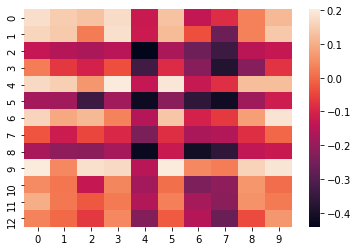

In [26]:
encoder_dim, decoder_dim, encoder_seq_length, decoder_seq_length = 100, 50, 10, 13
attention = MultiplicativeAttention(encoder_dim, decoder_dim)
encoder_hidden_states = torch.rand(encoder_seq_length, encoder_dim)
decoder_hidden_states = torch.rand(decoder_seq_length, decoder_dim)
weights = torch.FloatTensor(decoder_seq_length, encoder_seq_length)
for step in range(decoder_seq_length):
    context_vector = attention(decoder_hidden_states[step], encoder_hidden_states)
    weights[step] = attention._get_weights(decoder_hidden_states[step], encoder_hidden_states)
seaborn.heatmap(weights.detach().numpy())